# Heirarchical Agglomerative Clustering
Notebook for HAC exploration and implementation

In [1]:
import os
import numpy as np
import pandas as pd
import gensim as g
import nltk as n
import analyze_text as atxt
BASE_PATH = '/home/trevor/Projects/iot-diff/iot-tc/'
DATA_CNET_PATH = os.path.join(BASE_PATH, 'cnet-classifications.csv')
D2V_WIKI_PATH = os.path.join(BASE_PATH, 'enwiki_dbow/doc2vec.bin')

def tokenize(text):
    #stoplist = ['smart', 'device', 'devices', 'product']
    # Remove named entities
    # TODO necessary?
    named_entities = []
    chunked = n.ne_chunk(n.pos_tag(n.word_tokenize(text)))
    for chunk in chunked:
        if type(chunk) == n.tree.Tree:
           ne = ' '.join([token for token, pos in chunk.leaves()])
           text = text.replace(ne, '')
    # Tokenize
    tokens = atxt.tokenize(text)
    tokens = [token for token in tokens if len(token) >= 4]
    tokens = [atxt.get_lemma(token) for token in tokens if atxt.get_lemma(token)]
    tokens = [token for token in tokens if token.isalpha()]
    #tokens = [token for token in tokens if token not in stoplist]
    return tokens

df = pd.read_csv(DATA_CNET_PATH)

In [3]:
# Generate the input data for github.com/mkusner/wmd
df = pd.read_csv(DATA_CNET_PATH)
clean_texts = [(i, ' '.join(tokenize(d))) for i, d in list(zip(df.index, df['article_content']))]
content = ['{} \t {}'.format(str(i), t) for i, t in clean_texts]
content = '\n'.join(content)
with open('cnet_wmd_texts.txt', 'w') as f:
     f.write(content)

KeyboardInterrupt: 

In [10]:
# Load Word2Vec
import gensim
w2v = gensim.models.KeyedVectors.load_word2vec_format( \
    '../wmd/GoogleNews-vectors-negative300.bin', binary=True, limit=500000)  

In [16]:
# Check W2V pairs of documents
import numpy as np

def check_w2v_pair(doc1, doc2):
    # Prepare both docs and remove duplicate words
    doc1 = list(set(tokenize(doc1)))
    doc2 = list(set(tokenize(doc2)))
    doc1 = [w for w in doc1 if w in w2v.wv]
    doc2 = [w for w in doc2 if w in w2v.wv]
    # Get list of lowest word2vec scores between documents
    doc1_scores = []
    for w in doc1:
        min = 1000
        for other_w in doc2:
            score = w2v.wv.similarity(w, other_w)
            if 0 < score < min:
               min = score
        doc1_scores.insert(0, min)
    doc2_scores = []
    for w in doc2:
        min = 1000
        for other_w in doc1:
            score = w2v.wv.similarity(w, other_w)
            if 0 < score < min:
               min = score
        doc2_scores.insert(0, min)
    return doc1_scores, doc2_scores

def get_text(idx):
    return df.iloc[idx]['article_content']

In [21]:
p1 = check_w2v_pair(get_text(362), get_text(478))
p2 = check_w2v_pair(get_text(478), get_text(224))
print('same clust, diff dev: ', np.mean([np.mean(p) for p in p1]))
print('diff clust, same dev: ', np.mean([np.mean(p) for p in p2]))

same clust, diff dev:  0.00322734020411
diff clust, same dev:  0.0022192078403


In [2]:
# After running mkusner/wmd to get dist_matrix.pk, cluster based on it
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# Load it and make it symmetric (upper half triangular by default)
wmd_dist_mat = np.load(os.path.join(BASE_PATH, '../wmd/dist_matrix_numpy.pk'))
i_lower = np.tril_indices(648, -1)
wmd_dist_mat[i_lower] = wmd_dist_mat.T[i_lower]

agg_clust = AgglomerativeClustering(n_clusters=50, affinity='precomputed',
                                    linkage='complete', connectivity=wmd_dist_mat)
clusters = agg_clust.fit_predict(wmd_dist_mat)
df['cluster'] = clusters

In [27]:
len(df[df['cluster']==4])

273

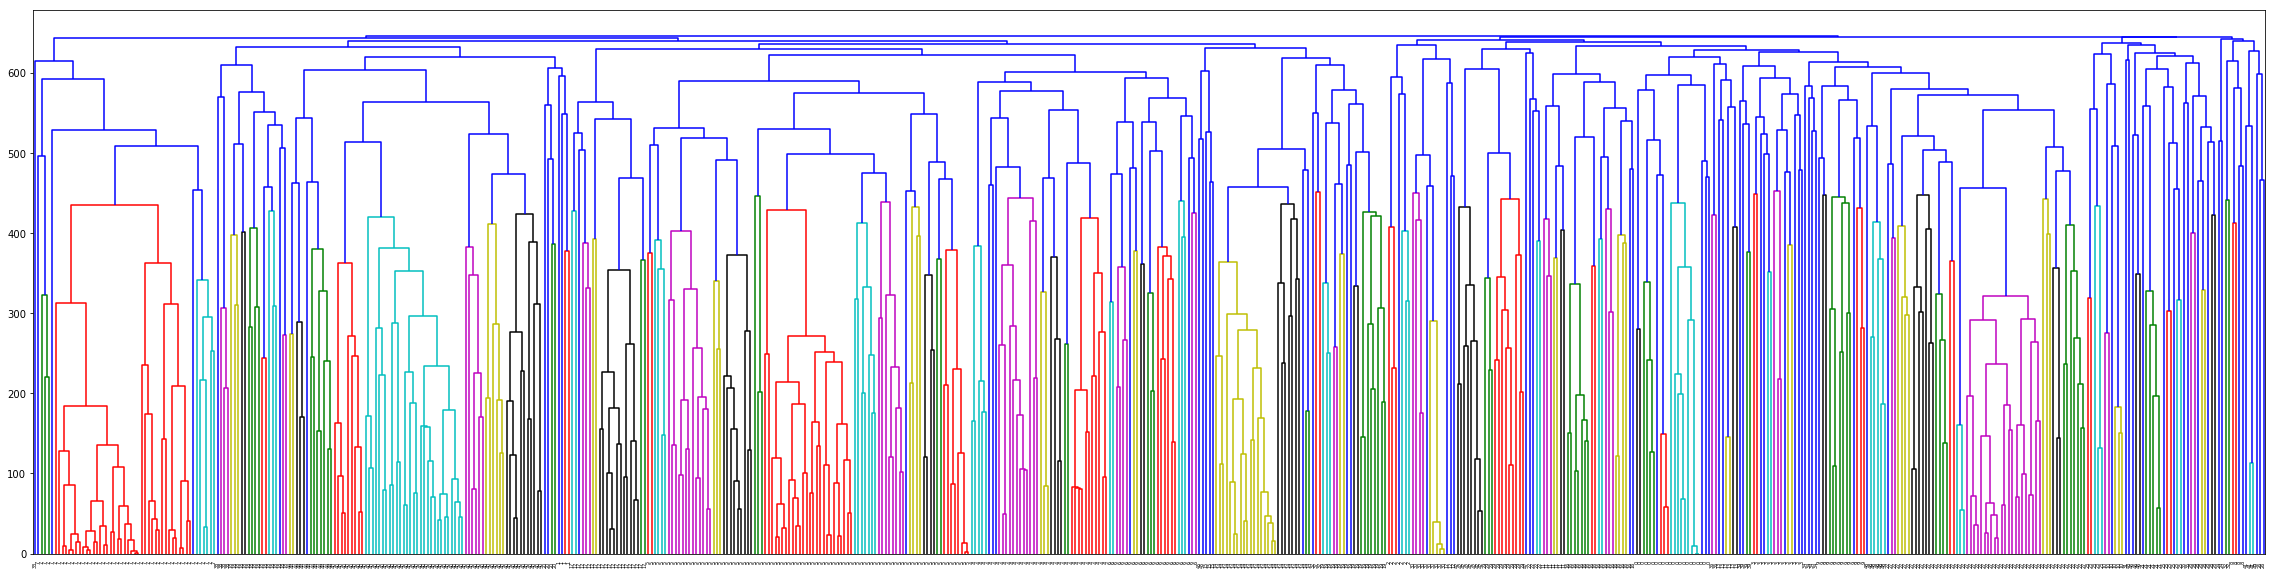

In [54]:
# Dendrogram
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(40, 10))
children = agg_clust.children_
distance = np.arange(children.shape[0])
n_obs = np.arange(2, children.shape[0]+2)
linkage = np.column_stack([children, distance, n_obs]).astype(float)
dendrogram(linkage, labels=agg_clust.labels_)#, truncate_mode='lastp', p=200)
plt.show()

In [106]:
import scipy as sp
linkage[56]

array([ 406.,  624.,   56.,   58.])

In [ ]:
# OLD
# Load the model and generate the document vectors
model = g.models.doc2vec.Doc2Vec.load(D2V_WIKI_PATH)
df = pd.read_csv(DATA_CNET_PATH)
df['vec'] = 'N/A'
for i, row in df.iterrows():
    text = row['article_content']
    row['vec'] = model.infer_vector(tokenize(text))
vecs = np.array(df['vec'].tolist())

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
import scipy as sp
dist_arr = sp.spatial.distance.squareform(wmd_dist_mat)
link_mat = linkage(dist_arr, 'complete')
c, coph_dists = cophenet(link_mat, pdist(wmd_dist_mat))
c
#df['cluster'] = sp.cluster.hierarchy.fcluster(link_mat, 3.2, 'distance')
#sp.cluster.hierarchy.fcluster(link_mat, 1.15, 'inconsistent')


0.30811555113669004

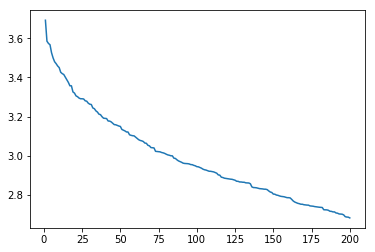

In [208]:
last = link_mat[-200:,2]
last_rev = last[::-1]
idxs = np.arange(1, len(last)+1)
plt.plot(idxs, last_rev)
plt.show()

In [217]:
# Get cluster TF-IDFS
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

ENGLISH_STOPS = set(nltk.corpus.stopwords.words('english'))

texts = []
for i, group in df.groupby('cluster'):
    texts.append('\n'.join(list(group['article_content'])))

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=200000, min_df=0.0,
                                    use_idf=True, lowercase=False,
                                    stop_words=ENGLISH_STOPS,
                                    tokenizer=tokenize,
                                    ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
feature_names = tfidf_vectorizer.get_feature_names()
feature_indices = {doc: tfidf_matrix[doc,:].nonzero()[1]
                    for doc in range(tfidf_matrix.shape[0])}
tfidf_scores = {doc: list(zip(ft_ind, [tfidf_matrix[doc,x] for x in ft_ind]))
                for doc, ft_ind in feature_indices.items()}
tfidf_sorted = {k: sorted(v, key=lambda x: x[1], reverse=True)[:5]
                for k,v in tfidf_scores.items()}

In [222]:
# Display
from IPython.display import display                               

for i, group in df.groupby('cluster'):
    print('Cluster '+str(i)+' ({})'.format(len(group)))
    print(', '.join(['{} ({:.2f})'.format(feature_names[w], s) for w,s in tfidf_sorted[i-1]]))
    display(group[['device_name', 'device_category']])
    print('\n\n')

Cluster 1 (52)
bulb (0.60), replacement (0.24), lumen (0.24), light (0.21), brightness (0.17)


,device_name,device_category
1,Feit Electric 6.5W Vintage Style LED,light bulb
19,Philips 60W Replacement WarmGlow Clear LED,light bulb
31,Cree 100W Replacement BR30 Floodlight LED,light bulb
44,Philips SceneSwitch BR30 LED,light bulb
101,Hyperikon 60W Equivalent LED,light bulb
117,Philips Hue White and Color Ambiance Candle,light bulb
132,Philips 60W Equivalent SceneSwitch LED,light bulb
133,GE 60W Equivalent HD Light LED,light bulb
310,Philips 40W Equivalent Candelabra LED,light bulb
311,Cree TW Series 40W Equivalent Candelabra LED,light bulb





Cluster 2 (1)
dimmer (0.23), dimmable (0.23), work dimmer (0.17), flicker (0.16), lumen (0.15)


,device_name,device_category
287,Utilitech Pro 60W Equivalent LED,light bulb





Cluster 3 (21)
sensor (0.35), camera (0.26), home (0.18), motion (0.16), system (0.16)


,device_name,device_category
64,Intellithings RoomMe,motion sensor
76,Hive Welcome Home Standard,starter kit
173,Ooma Home Monitoring System,security system
196,Grid Connect ConnectSense Bluetooth Extender,Wireless extender
487,Honeywell Lyric Home Security System,assistant speaker
488,E Fun Nexturn Home Automation System,starter kit
493,D-Link HD Wi-Fi Camera,camera
494,D-Link Connected Home Hub,hub
510,Quirky Tripper,house monitor kit
511,Quirky Spotter Uniq,air quality





Cluster 4 (74)
camera (0.51), storage (0.20), security (0.20), motion (0.18), video (0.15)


,device_name,device_category
3,Honeywell Smart Home Security System,security system
7,Wink Lookout,security system
9,Guardzilla 360,camera
20,August Doorbell Cam Pro,doorbell
21,Netgear Arlo Pro 2,camera
24,Ring Protect,security system
25,Samsung SmartThings ADT Home Security Starter Kit,security system
51,Reolink Argus Security Camera,camera
54,Honeywell Lyric C1 Wi-Fi Security Camera,camera
55,SimpliSafe SimpliCam,camera





Cluster 5 (8)
camera (0.32), night vision (0.12), home (0.11), vision (0.11), thermal (0.10)


,device_name,device_category
35,Tend Secure Lynx Solar Outdoor Camera,camera
247,Bosch Eyes Outdoor Camera,camera
248,Bosch 360 Degree Indoor Camera,camera
315,LG Rolling Bot,pet
348,Ezviz Mini Cube,camera
356,Flir Scout TK,camera
376,Ulo,camera
483,Yetu Smart Home Gateway,hub





Cluster 6 (22)
thermostat (0.60), home (0.17), temperature (0.15), wire (0.15), smart (0.15)


,device_name,device_category
36,Nest Thermostat E,thermostat
59,Lennox iComfort E30 Smart Thermostat,thermostat
90,Emerson Sensi Touch Wi-Fi Thermostat,thermostat
98,Ecobee4 Smart Thermostat,thermostat
127,Lux Geo Thermostat,thermostat
186,Carrier Cor 5C Thermostat,thermostat
221,Honeywell Lyric T5 Wi-Fi Thermostat,thermostat
226,Ecobee3 Lite Smart Thermostat,thermostat
230,Emerson Sensi Wi-Fi Programmable Thermostat,thermostat
243,Emerson 1F78-151 Thermostat,thermostat





Cluster 7 (94)
bulb (0.51), light (0.33), color (0.19), smart (0.18), control (0.16)


,device_name,device_category
5,Noon Smart Lighting Starter Kit,light bulb
16,Sylvania Smart Plus Zigbee LED,light bulb
23,Lifx Beam,light bulb
30,Lifx Mini Wi-Fi Smart Bulb,light bulb
33,C by GE Lamp with Alexa,assistant speaker
34,Wiz Color Wi-Fi Smart LED Starter Kit,light bulb
50,iDevices Dimmer Switch,light switch
53,Sylvania Smart Multicolor LED,light bulb
58,Oomi Home Starter Kit,starter kit
63,Leviton Decora Smart Dimmer with HomeKit,light switch





Cluster 8 (66)
smart (0.28), home (0.25), plug (0.21), control (0.20), like (0.17)


,device_name,device_category
6,Amazon Echo Plus,assistant speaker
11,Amazon Echo2017,assistant speaker
12,Harman Kardon Invoke,assistant speaker
32,Fabriq Chorus Smart Speaker with Amazon Alexa,speaker
37,iHome iAVS16 Alarm Clock with Amazon Alexa,alarm clock
56,Eufy Genie,assistant speaker
61,Swidget Outlet,outlet
70,Amazon Echo Show,assistant speaker
71,Shortcut Labs Flic Hub,smart button
74,Cnct IntelliPlug,outlet





Cluster 9 (5)
padlock (0.23), phone (0.18), tag (0.15), item (0.13), ring (0.12)


,device_name,device_category
81,TrackR Pixel,tracker
165,Griffin Technology Connected Mirror,mirror
377,TrackR Atlas,tracker
492,TrackR Bravo,tracker
641,Master Lock Bluetooth Smart Padlock,smart lock





Cluster 10 (28)
lock (0.72), deadbolt (0.26), door (0.25), smart lock (0.17), smart (0.13)


,device_name,device_category
2,Kwikset Obsidian Keywayless Smart Lock,smart lock
4,Friday Smart Lock,smart lock
17,igloohome Smart Deadbolt 02,smart lock
45,Otto Smart Lock,smart lock
123,Kwikset Convert Smart Lock Conversion Kit,smart lock
128,Yale Assure Keyless Bluetooth Smart Lock,smart lock
200,Kwikset Premis,smart lock
217,Kwikset Kevo 2nd Gen Bluetooth Smart Lock,smart lock
229,Smart Armor Smart Cube,smart lock
291,August Smart Lock HomeKit Enabled,smart lock





Cluster 11 (3)
battery (0.37), power (0.15), spotlight (0.14), camera (0.13), bulb (0.12)


,device_name,device_category
62,Ring Spotlight Cam,camera
282,Black+Decker Smartech Battery,battery
339,BeOn BR30 Smart LED Floodlight,light bulb





Cluster 12 (19)
camera (0.25), doorbell (0.20), security (0.17), battery (0.15), door (0.15)


,device_name,device_category
14,Remo+ DoorCam,camera
105,LookOut Charger,camera
121,Pebby,pet
222,Gate Labs Gate,smart lock
224,iSmartAlarm iCamera Keep Pro,camera
228,Ding Smart Doorbell,doorbell
240,Yale Look Video Doorbell,doorbell
241,People Power Presence 360,security system
420,Blue Frog Robotics Buddy,robot
421,Branto,security system





Cluster 13 (7)
sleep (0.58), mattress (0.22), pillow (0.17), snoring (0.13), light (0.12)


,device_name,device_category
47,Eight Sleep Mars+ Smart Mattress,mattress
96,Serta iComfort TempTouch,mattress
97,Mode Modern Sunrise Smart Pillow,pillow
152,Smart Nora,sleep
342,Nox Smart Sleep System,sleep
381,Juvo,sleep
602,Withings Aura,sleep





Cluster 14 (10)
plant (0.78), soil (0.16), garden (0.14), recommendation (0.14), water (0.13)


,device_name,device_category
15,GardenSpace,garden monitor
350,Edyn Water Valve,garden monitor
419,Edyn Garden Sensor,garden monitor
451,nthing Planty,garden monitor
467,Digital Spring Daisy,garden monitor
501,Ohneka Farms Root,garden monitor
572,"Koubachi Wi-Fi Plant Sensor, Outdoor",garden monitor
577,Parrot Flower Power,garden monitor
580,Oso Technologies PlantLink,garden monitor
618,Click & Grow Smart Flowerpot,garden monitor





Cluster 15 (3)
woman (0.22), weight (0.13), scale (0.12), body (0.10), numbers (0.10)


,device_name,device_category
95,ShapeScale,scale
178,Bloomlife,woman health
363,QardioBase,scale





Cluster 16 (20)
alarm (0.39), smoke (0.31), detector (0.26), sensor (0.23), leak (0.22)


,device_name,device_category
29,Delta Leak Detector,leak detector
69,Halo Smart Labs Halo+ Smart Smoke & CO Alarm w...,air hazard
78,Loop Labs Notion,house monitor kit
85,LeakSmart Complete Home Water Protection System,leak detector
113,Roost Smart Water Leak and Freeze Detector,leak detector
177,Netatmo Smart Smoke Alarm,air hazard
205,Roost Smart Smoke Alarm RSA-400,air hazard
208,Everspring Z-Wave Wireless Flood Detector,leak detector
209,Samsung SmartThings Water Leak Sensor,leak detector
210,Aeon Labs Aeotec Water Sensor,leak detector





Cluster 17 (4)
stove (0.49), burner (0.23), oven (0.18), cooking (0.17), fire (0.12)


,device_name,device_category
46,Wallflower,kitchen
129,IGuardStove Intelligent,kitchen
144,React,kitchen
428,Lumkani Fire Detector,air hazard





Cluster 18 (1)
child room (0.24), child (0.23), first (0.21), safe monitor (0.14), monoxide network (0.14)


,device_name,device_category
193,First Alert Onelink Environment Monitor,air quality





Cluster 19 (27)
child (0.39), baby (0.36), parent (0.24), monitor (0.23), feature (0.16)


,device_name,device_category
151,iBaby Yobi,baby monitor
155,DockATot CloudTot,baby monitor
158,4moms Moxi Stroller,stroller
159,Happiest Baby Snoo,baby monitor
160,Hubble Hugo,camera
172,Fisher-Price Think and Learn Smart Cycle,toy
181,C-Way Memoo,toy
192,Aristotle by Nabi,assistant speaker
251,Project Nursery Video Baby Monitor System,baby monitor
252,Summer Infant In View Digital Color Video Baby...,baby monitor





Cluster 20 (22)
sprinkler (0.38), hyve (0.26), sensor (0.18), zone (0.18), smart (0.17)


,device_name,device_category
28,Blossom Smart Watering Controller,sprinkler
49,Orbit B-hyve,sprinkler
57,Rachio Smart Sprinkler Controller Generation 2,sprinkler
82,Elgato Eve Degree,air quality
111,BloomSky Sky2 Weather Camera Station,weather station
263,BloomSky Plus,weather station
297,Move It Smart Home Gym,exercise
298,Eggplant Technologies Move It,exercise
331,Frigidaire Gallery Cool Connect,AC
374,Etwater,sprinkler





Cluster 21 (2)
vacuum (0.37), robot vacuum (0.24), cleaning (0.20), robot (0.19), carpet (0.16)


,device_name,device_category
163,Black & Decker Smartech Robotic Vacuum,cleaner
388,Neato Botvac Connected Robot Vacuum,cleaner





Cluster 22 (6)
plug (0.18), outlet (0.17), switch (0.17), wall (0.16), panel (0.15)


,device_name,device_category
27,Lifx Tile,light bulb
48,Nanoleaf Aurora Rhythm,light bulb
174,Switchmate Power,outlet
175,Switchmate Bright,light switch
505,Brio Safe Outlet,outlet
515,FreshAir Sensor AirGuard,air hazard





Cluster 23 (19)
shower (0.22), mattress (0.19), like (0.14), charge (0.14), smart (0.12)


,device_name,device_category
75,Amazon Echo Look,assistant speaker
107,Cambridge Sound Management Nightingale,sleep
116,Storebound Sobro,furniture
118,Viio Vezzo,assistant speaker
119,Fremo Evo,assistant speaker
125,Petnet SmartFeeder,pet
126,U by Moen Smart Shower,shower
137,Teforia Infuser,kitchen
195,Sleep Number 360 Smart Bed,mattress
207,Sleep Number it,mattress





Cluster 24 (4)
candle (0.26), flame (0.20), salt (0.17), mirror (0.15), wick (0.14)


,device_name,device_category
92,Smalt,kitchen
236,LuDela Smart Candle,light bulb
278,Simplehuman Sensor Mirror Pro,mirror
643,Meural,decoration





Cluster 25 (78)
system (0.31), home (0.29), sensor (0.22), camera (0.19), smart (0.17)


,device_name,device_category
0,1-Ring Moon,camera
8,Lynky,assistant speaker
10,Cherry Labs Cherry Home,security system
22,Vivint Smart Home,security system
43,TruSense,house monitor kit
65,Mistbox2017,AC
66,Xfinity Home,security system
80,Ambi Climate 2,AC
84,Dojo,security system
94,Lighthouse Interactive Assistant,camera





Cluster 26 (5)
burner (0.36), cooking (0.33), grill (0.26), cook (0.24), temperature (0.19)


,device_name,device_category
52,Weber Genesis II E-310,kitchen
100,Nomiku Sous Chef,kitchen
104,Hestan Cue,kitchen
369,Pantelligent,kitchen
463,Anova Precision Cooker,kitchen





Cluster 27 (6)
wine (0.51), beer (0.36), bottle (0.30), cartridge (0.24), wort (0.16)


,device_name,device_category
13,HOPii,beer brewer
185,PicoBrew Freestyle,beer brewer
299,Synek Somm,kitchen
303,iGulu,beer brewer
305,Kuvée Bottle,kitchen
318,BrewJacket Immersion Pro,kitchen





Cluster 28 (1)
toast (0.36), toaster (0.30), bread (0.24), toast bread (0.18), dial (0.10)


,device_name,device_category
164,Griffin Technology Connected Toaster,kitchen





Cluster 29 (1)
scent (0.35), sleep (0.17), incense (0.15), patent scent (0.15), candle incense (0.15)


,device_name,device_category
182,Sensorwake Oria,sleep





Cluster 30 (3)
brush (0.54), brushing (0.38), toothbrush (0.18), hair (0.18), tooth (0.15)


,device_name,device_category
189,Kérastase Hair Coach Powered by Withings,beauty
273,Philips Sonicare FlexCare Platinum Connected,toothbrush
314,Oral-B Genius 9000,toothbrush





Cluster 31 (12)
garage (0.39), door (0.38), garage door (0.30), opener (0.29), fridge (0.17)


,device_name,device_category
26,Samsung RF265BEAESR French Door Family Hub Ref...,refrigerator
42,Haier Link Cook Series,refrigerator
60,Liftmaster Automatic Garage Door Lock,smart lock
72,Amazon Dash Wand with Alexa2017,barcode scanner
283,Home8 Smart Garage Starter Kit,starter kit
313,Alottazs Labs Garageio,garage opener
360,Whirlpool WRF995FIFZ Smart French Door Refrige...,refrigerator
372,Hiku Labs Hiku2015,barcode scanner
443,Chamberlain Wi-Fi Garage Door Opener,garage opener
485,Archos Kitchen Screen,barcode scanner





Cluster 32 (2)
clean (0.15), particulate matter (0.12), particulate (0.11), matter (0.10), like (0.10)


,device_name,device_category
166,ShadeCraft Sunflower,shade
265,Wynd,air quality





Cluster 33 (8)
robot (0.39), mower (0.22), lawn (0.15), yard (0.12), robot vacuum (0.12)


,device_name,device_category
39,LG Lawn Mower Robot,lawn mower
41,Qihan Sanbot Nano,robot
150,Ecovacs Robotics Unibot,cleaner
170,LG Lawn Mowing Robot,lawn mower
171,LG Hub Robot,robot
184,Emotech Olly,robot
244,Windowmate,cleaner
584,Kyodo America LawnBott,lawn mower





Cluster 34 (2)
utensil (0.29), food (0.23), spoon (0.18), smart utensil (0.18), calorie (0.13)


,device_name,device_category
162,Habit,biometric analyzer
338,Spün Utensil,kitchen





Cluster 35 (2)
bulb (0.30), speaker (0.26), speaker bulb (0.17), tablet (0.16), playback (0.11)


,device_name,device_category
40,Lenovo Home Assistant Pack,assistant speaker
343,Sengled Voice Control LED,light bulb





Cluster 36 (4)
appliance (0.28), sou (0.15), refrigerator (0.14), search recipe (0.13), smart (0.12)


,device_name,device_category
18,Smart Refrigerators,refrigerator
148,Gourmia GCM4500,kitchen
149,Mykie,assistant speaker
154,Hello Egg,assistant speaker





Cluster 37 (3)
garbage (0.23), grocery list (0.18), scan (0.18), grocery (0.16), empty (0.16)


,device_name,device_category
141,Nutrismart,scale
179,Eugene,barcode scanner
191,GeniCan,barcode scanner





Cluster 38 (3)
medicine (0.34), pill (0.30), folding (0.17), machine (0.15), laundry (0.13)


,device_name,device_category
38,Panasonic Sustainable Maintainer,laundry
143,Seven Dreamers Laundroid,laundry
312,Hero Smart Appliance,medication tracker


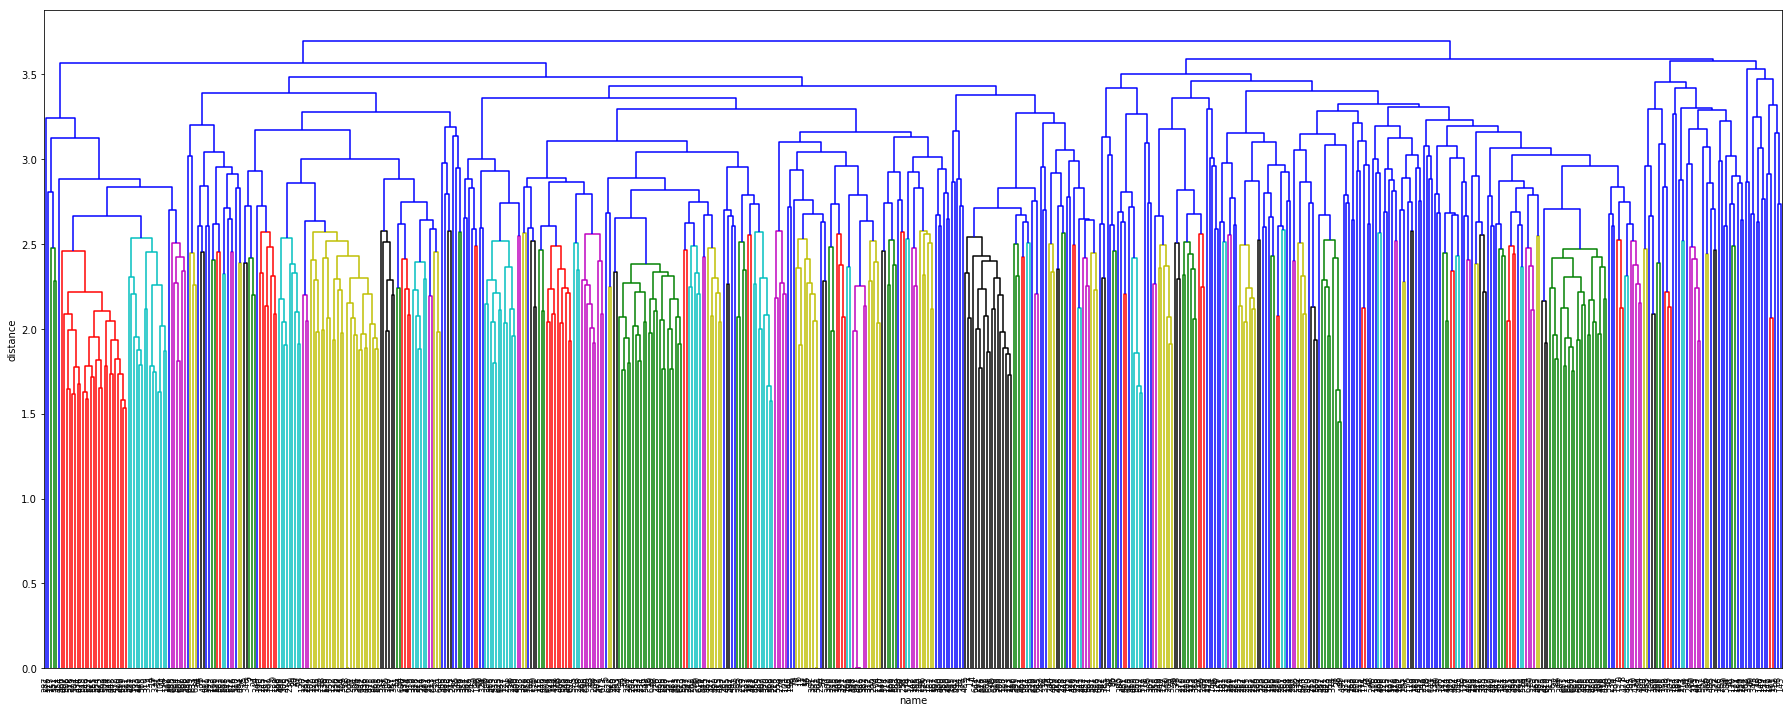

In [204]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'

plt.figure(figsize=(25, 10))
plt.xlabel('name')
plt.ylabel('distance')
dendrogram(
    link_mat,
    leaf_rotation=90.,
leaf_font_size=8.,
#truncate_mode='lastp',
#p=200,
show_contracted=True
)
plt.tight_layout()
plt.show()